# Regressão logística com Python

Para esta aula, estaremos trabalhando com o [Conjunto de dados do Titanic da Kaggle](https://www.kaggle.com/c/titanic). Este é um conjunto de dados muito famoso e muitas vezes é o primeiro passo em Machine Learning!

Vamos tentar montar um algoritmo de classificação que prediz sobrevivente ou falecido utilizando regressão logística no Python.

Usaremos uma versão "semi-limpa" do conjunto de dados do Titanic. Se você usar o conjunto de dados hospedado diretamente no Kaggle, talvez seja necessário fazer uma limpeza adicional não mostrada neste notebook.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Os dados

Vamos começar lendo o arquivo titanic_train.csv em um DataFrame pandas.

In [2]:
# Vamos ler o arquivo 911.csv localizado no HD Externo como um dataframe chamado "TitanicTrain"
TitanicTrain = pd.read_csv('/media/felipe/SAMSUNG/LAPTOP RECENTE/felipe/Python3.7/udemyCOURSES/PythonParaDataScienceEMachineLearning/Python-Data-Science-and-Machine-Learning-Bootcamp/5. Machine Learning/Regressão Logística/titanic_train.csv')

In [3]:
TitanicTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
TitanicTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Análise de dados exploratórios

Vamos começar algumas análises de dados exploratórios. Começaremos por verificar os dados que faltam!

## Dados ausentes

Podemos usar seaborn para criar um mapa de calor simples para ver onde estamos perdendo dados!

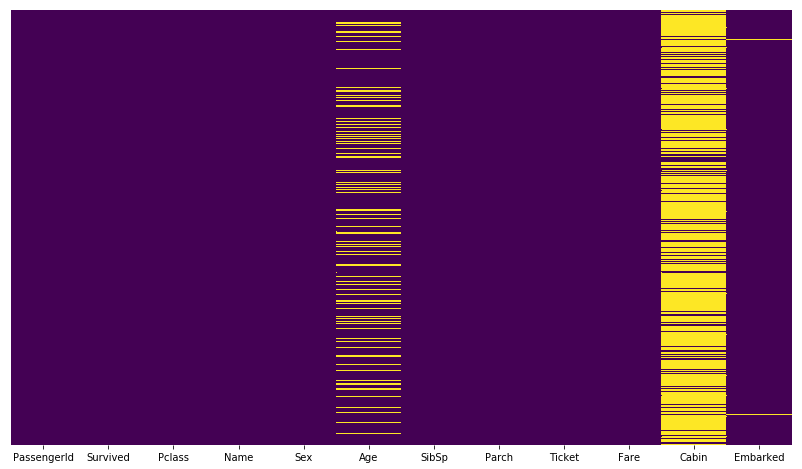

In [16]:
plt.figure(figsize=(14, 8))
sns.heatmap(TitanicTrain.isnull(), yticklabels=False,cbar=False,cmap='viridis')

#### Como podemos ver, as colunas "Age", "Cabin" e "Embarked" estão incompletas e possuem elementos tipo NaN. Depois veremos como calibrar nosso DataFrame para uma forma na qual possamos realizar operações de regressão logística.

Aproximadamente 20% dos dados de idade estão faltando. A proporção de idade que falta é provavelmente pequena o suficiente para que possamos fazer uma substituição razoável com alguma forma de imputação de dados. Olhando para a coluna Cabin, porém, parece que estamos perdendo muito desses dados para fazermos o mesmo. Provavelmente vamos descartar isso mais tarde ou mudá-lo para outro "Cabin Conhecido: 1 ou 0"

Continuemos visualizando mais alguns dos dados! Confira o vídeo para obter explicações completas sobre esses gráficos, este código é apenas para servir como referência.

## Análise Exploratória de Dados

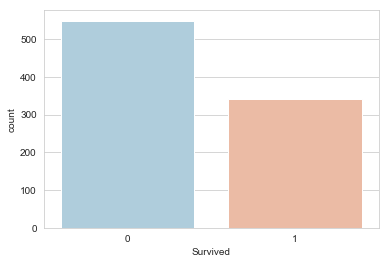

In [18]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=TitanicTrain,palette='RdBu_r')

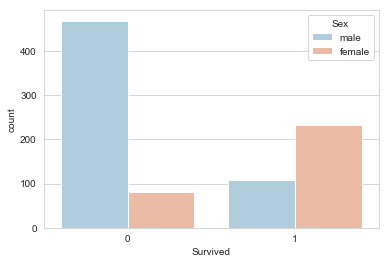

In [19]:
sns.countplot(x='Survived',data=TitanicTrain,palette='RdBu_r', hue='Sex')

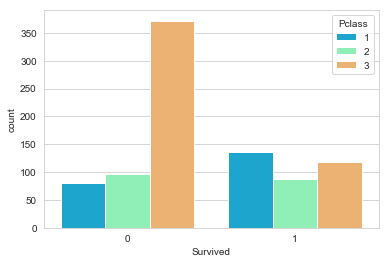

In [21]:
sns.countplot(x='Survived',data=TitanicTrain, hue='Pclass', palette='rainbow')

In [23]:
# Vejamos como estão dispostas as idades das pessoas
TitanicTrain['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
5       NaN
6      54.0
7       2.0
8      27.0
9      14.0
10      4.0
11     58.0
12     20.0
13     39.0
14     14.0
15     55.0
16      2.0
17      NaN
18     31.0
19      NaN
20     35.0
21     34.0
22     15.0
23     28.0
24      8.0
25     38.0
26      NaN
27     19.0
28      NaN
29      NaN
       ... 
861    21.0
862    48.0
863     NaN
864    24.0
865    42.0
866    27.0
867    31.0
868     NaN
869     4.0
870    26.0
871    47.0
872    33.0
873    47.0
874    28.0
875    15.0
876    20.0
877    19.0
878     NaN
879    56.0
880    25.0
881    33.0
882    22.0
883    28.0
884    25.0
885    39.0
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

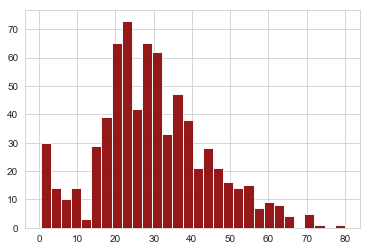

In [27]:
TitanicTrain['Age'].hist(bins=30, color='darkred', alpha=0.9)

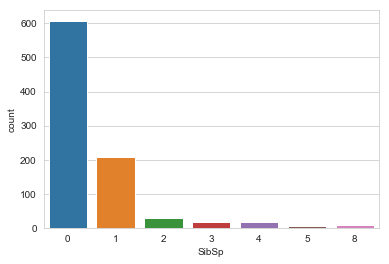

In [29]:
# Agora vejamos a distribuição de pessoas que acompanhavam os passageiros no navio
sns.countplot(x='SibSp',data=TitanicTrain)

#### A figura acima mostra que a maioria  das pessoas vieram ao Titanic desacompanhadas. Vamos mostrar que os dois gráficos acima se combinam indicando que a maioria dos passageiros eram jovens entre 20 e 30 anos desacompanhados. Vamos pegar os elementos desacompanhados ('SibSp == 0') e mostrar que a distribuição deles em relação à idade tem a mesma cara da distribuição acima da figura acima.

In [36]:
TitanicTrain[TitanicTrain['SibSp'] == 0]['Age'].head(20)

2     26.0
4     35.0
5      NaN
6     54.0
8     27.0
11    58.0
12    20.0
14    14.0
15    55.0
17     NaN
19     NaN
20    35.0
21    34.0
22    15.0
23    28.0
26     NaN
28     NaN
29     NaN
30    40.0
32     NaN
Name: Age, dtype: float64

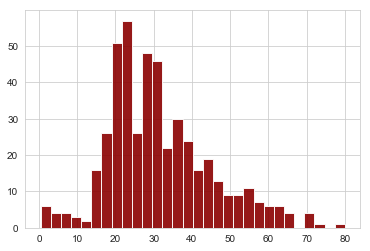

In [37]:
TitanicTrain[TitanicTrain['SibSp'] == 0]['Age'].hist(bins=30, color='darkred', alpha=0.9)

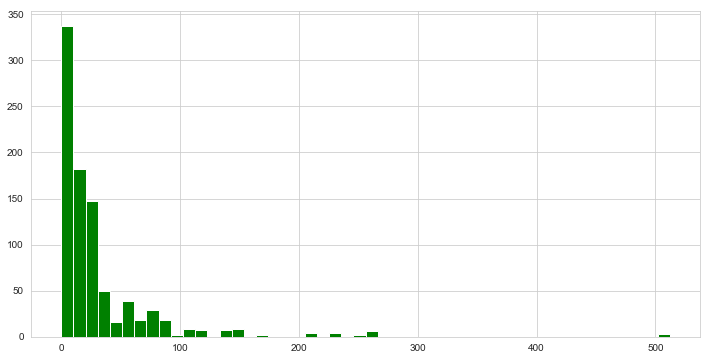

In [40]:
# Vejamos agora a distribuição dos tickets
TitanicTrain['Fare'].hist(bins=50, color='green', figsize=(12,6))

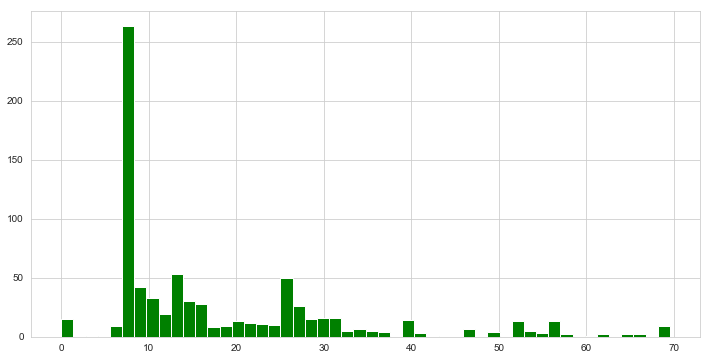

In [41]:
# Vejamos a mesma figura para casos em que o ticket foi menor que 70
TitanicTrain[TitanicTrain['Fare'] < 70]['Fare'].hist(bins=50, color='green', figsize=(12,6))

# Limpando os dados

Queremos preencher dados de idade faltantes, em vez de simplesmente deixar cair as linhas de dados de idade que faltam. Uma maneira de fazer isso é preenchendo a idade média de todos os passageiros (imputação).
No entanto, podemos ser mais inteligentes sobre isso e verificar a idade média pela classe de passageiros. Para isso, vamos primeiro visualizar a distribuição das idades em relação às classes.

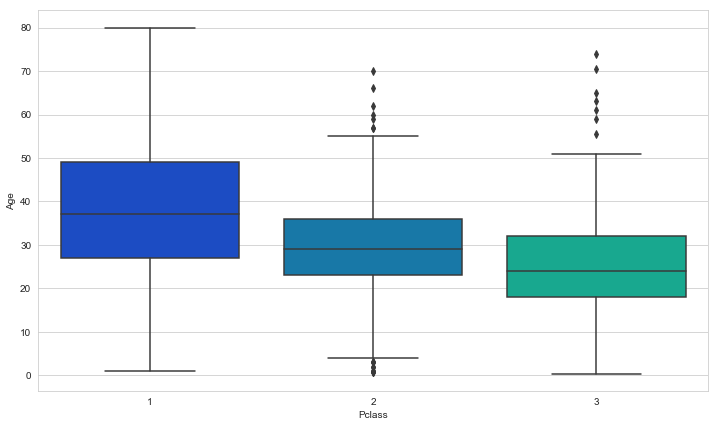

In [42]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass', y='Age', data=TitanicTrain, palette='winter')

#### Do gráfico acima observamos que 

*) Primeira classe: Idade média de 37 anos

*) Segunda classe: Idade média de 29 anos

*) Terceira classe: Idade média de 24 anos

#### Em casos como este em que temos dados faltantes basicamente temos 3 abordagens possíveis para lidar com isso, as quais são:

1) Deletar os dados;

2) Preencher os valores com a média de idade geral;

3) Preencher os dados com a média das suas correspondentes classes.


Neste caso seguiremos a terceira opção.

#### Usaremos esses valores de idade média para inputar com base em Pclass for Age.

In [52]:
# Primeiro vamos criar a seguinte função cujo parâmetro de input é um DataFrame de 2 colunas

def inputar_idade(cols):
    Idade = cols[0]
    Classe = cols[1]
    
    if pd.isnull(Idade):
        if Classe == 1:
            return 37
        
        elif Classe == 2:
            return 29
        
        else: 
            return 24
   
    else:
        return Idade

In [55]:
# Agora vamos aplicar a função "inputar_idade" 
TitanicTrain['Age'] = TitanicTrain[['Age','Pclass']].apply(inputar_idade,axis = 1)

In [59]:
# Agora os dados da coluna Age estão todos preenchidos com valores
TitanicTrain['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
5      24.0
6      54.0
7       2.0
8      27.0
9      14.0
10      4.0
11     58.0
12     20.0
13     39.0
14     14.0
15     55.0
16      2.0
17     29.0
18     31.0
19     24.0
20     35.0
21     34.0
22     15.0
23     28.0
24      8.0
25     38.0
26     24.0
27     19.0
28     24.0
29     24.0
       ... 
861    21.0
862    48.0
863    24.0
864    24.0
865    42.0
866    27.0
867    31.0
868    24.0
869     4.0
870    26.0
871    47.0
872    33.0
873    47.0
874    28.0
875    15.0
876    20.0
877    19.0
878    24.0
879    56.0
880    25.0
881    33.0
882    22.0
883    28.0
884    25.0
885    39.0
886    27.0
887    19.0
888    24.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

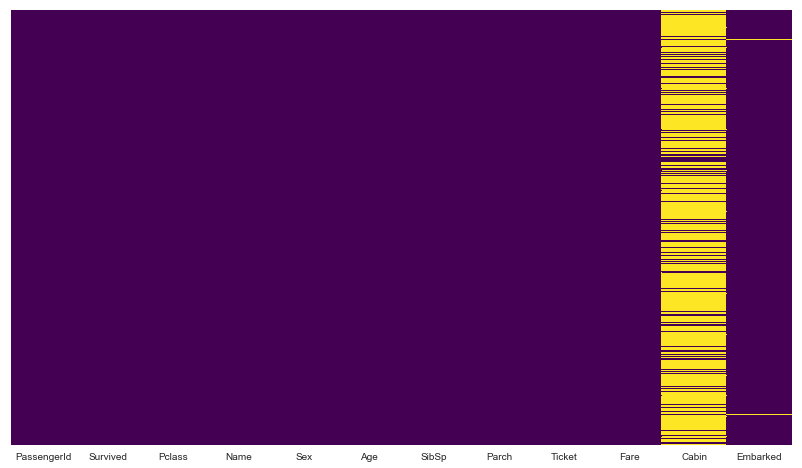

In [58]:
### Agora vamos verificar o mapa de calor novamente!
plt.figure(figsize=(14, 8))
sns.heatmap(TitanicTrain.isnull(), yticklabels=False,cbar=False,cmap='viridis')

### No caso da coluna "Cabin", como temos tantos dados faltantes não convém acrescentarmos alguns com média. Melhor descartá-los.

In [60]:
del TitanicTrain['Cabin']

# podia também ser feito assim:                  train.drop('Cabin',axis=1,inplace=True)

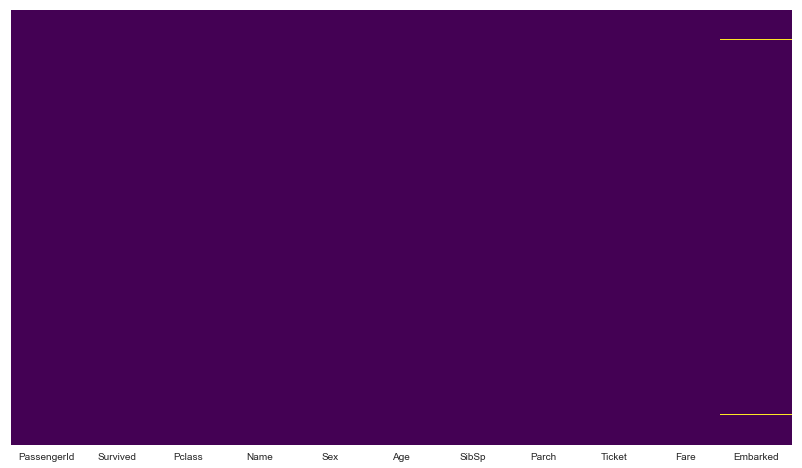

In [61]:
### Agora vamos verificar o mapa de calor novamente!
plt.figure(figsize=(14, 8))
sns.heatmap(TitanicTrain.isnull(), yticklabels=False,cbar=False,cmap='viridis')

#### Agora no último caso da coluna "Embarked", devemos apenas apagar as linhas faltantes. Para isso usaremos o comando 'dropna' que apaga linhas que contém qualquer tipo de informação falsa. 

In [62]:
TitanicTrain.dropna(inplace=True)

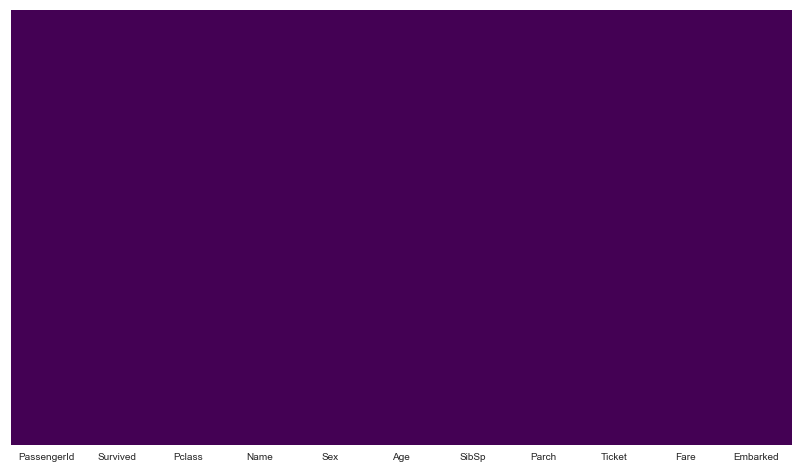

In [63]:
### Agora vamos verificar o mapa de calor novamente!
plt.figure(figsize=(14, 8))
sns.heatmap(TitanicTrain.isnull(), yticklabels=False,cbar=False,cmap='viridis')

In [65]:
TitanicTrain.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


## Convertendo recursos categóricos

### Próximo passo para tratar os nossos dados para poder utilizá-los no nosso modelo de Machine Learning: 

Precisamos converter características categóricas em variáveis dummy usando pandas! Caso contrário, nosso algoritmo de Machine Learning não será capaz de aceitar esses recursos diretamente como entradas.

#### Para transformar variáveis categóricas que de certa forma podem ser convertidas em números, o Pandas tem uma função chamada "get_dummies"

In [66]:
TitanicTrain['Sex'].head(12)

0       male
1     female
2     female
3     female
4       male
5       male
6       male
7       male
8     female
9     female
10    female
11    female
Name: Sex, dtype: object

In [67]:
# Por exemplo, vamos aplicar isso na coluna sex

pd.get_dummies(TitanicTrain['Sex'])

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1
7,0,1
8,1,0
9,1,0


In [70]:
# Nesse caso do 'Sex', como uma só coluna de informação já diz tudo sobre a outra, 
# para evitar que o nosso modelo de Machine Learning se atrapalhe vamos deixar apenas uma das colunas.
# Isso pode evitar um fenômeno problemático conhecido como MULTI-COLINEARIDADE.
pd.get_dummies(TitanicTrain['Sex'], drop_first=True)

,male
0,1
1,0
2,0
3,0
4,1
5,1
6,1
7,1
8,0
9,0


In [71]:
sex = pd.get_dummies(TitanicTrain['Sex'], drop_first=True)

In [72]:
TitanicTrain.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


In [73]:
TitanicTrain['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

#### Vamos também criar um dummy para a variável 'Embarked'

In [76]:
# Também usamos o drop_first=True porque dado que já tenhamos os dois primeiros informações (Q e S) 
# obrigatoriamente já sabemos qual é a terceira informação
embark = pd.get_dummies(TitanicTrain['Embarked'], drop_first=True)

In [77]:
embark

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
5,1,0
6,0,1
7,0,1
8,0,1
9,0,0


In [78]:
TitanicTrain.head(14)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


#### Vamos agora excluir as variáveis que são irrelevantes para o nosso modelo, tais como Name, PassengerId e Ticket. Também devemos tirar as colunas 'Sex' e 'Embarked' e colocar as colunas dummies que criamos para estas variáveis.

In [80]:
TitanicTrain.drop(['Name', 'PassengerId', 'Ticket', 'Sex'], axis=1, inplace=True)

In [81]:
# Com isso temos:
TitanicTrain.head(14)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
0,0,3,22.0,1,0,7.2500,S
1,1,1,38.0,1,0,71.2833,C
2,1,3,26.0,0,0,7.9250,S
3,1,1,35.0,1,0,53.1000,S
4,0,3,35.0,0,0,8.0500,S
5,0,3,24.0,0,0,8.4583,Q
6,0,1,54.0,0,0,51.8625,S
7,0,3,2.0,3,1,21.0750,S
8,1,3,27.0,0,2,11.1333,S
9,1,2,14.0,1,0,30.0708,C


#### Agora vamos concatenar essa tabela com as tabelas 'sex' e 'embark' que criamos.

In [82]:
TitanicTrain = pd.concat([TitanicTrain, sex, embark], axis=1)

In [83]:
TitanicTrain.head(14)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,male,Q,S
0,0,3,22.0,1,0,7.2500,S,1,0,1
1,1,1,38.0,1,0,71.2833,C,0,0,0
2,1,3,26.0,0,0,7.9250,S,0,0,1
3,1,1,35.0,1,0,53.1000,S,0,0,1
4,0,3,35.0,0,0,8.0500,S,1,0,1
5,0,3,24.0,0,0,8.4583,Q,1,1,0
6,0,1,54.0,0,0,51.8625,S,1,0,1
7,0,3,2.0,3,1,21.0750,S,1,0,1
8,1,3,27.0,0,2,11.1333,S,0,0,1
9,1,2,14.0,1,0,30.0708,C,0,0,0


In [85]:
# Agora só nos falta excluir os dados referentes à coluna 'Embarked', 
# pois são do tipo string que não são mais importantes para o nosso modelo.

del TitanicTrain['Embarked']

In [86]:
TitanicTrain.head(14)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1
5,0,3,24.0,0,0,8.4583,1,1,0
6,0,1,54.0,0,0,51.8625,1,0,1
7,0,3,2.0,3,1,21.0750,1,0,1
8,1,3,27.0,0,2,11.1333,0,0,1
9,1,2,14.0,1,0,30.0708,0,0,0


Ótimo! Nossos dados agora estão calibrados para o nosso modelo de Regressão Logística.


# Construindo um modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes (há outro arquivo test.csv que você pode usar ao invés, caso queira usar todos esses dados para treinar). Por simplicidade e praticidade, os dados do TitanicTrain serão os nossos dados gerais para que não precisemos dos dados TitanicTest da Kaggle.

## Divisão treino-teste

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
# Nosso X são todas as colunas fora a coluna 'Survived'. E para que essa retirada só ocorra aqui sem tirar de todo
# o DataFrame, não devemos colocar o inplace=True.
X = TitanicTrain.drop('Survived',axis=1)

In [89]:
Y = TitanicTrain['Survived']

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [91]:
from sklearn.linear_model import LogisticRegression

In [92]:
LogisticModel = LogisticRegression()

In [93]:
# Agora podemos calibrar o modelo de acordo com a classe LogisticRegression
LogisticModel.fit(X_train, Y_train)

/home/felipe/Python/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Predictions

In [94]:
Predictions = LogisticModel.predict(X_test)

## Avaliação

Podemos verificar a precisão, o recall e a pontuação f1 usando o relatório de classificação!

In [95]:
from sklearn.metrics import classification_report

In [96]:
print(classification_report(Y_test, Predictions))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       169
           1       0.76      0.61      0.68        98

   micro avg       0.79      0.79      0.79       267
   macro avg       0.78      0.75      0.76       267
weighted avg       0.78      0.79      0.78       267



### Portanto notemos que nosso modelo acertou em média 78% dos casos, na qual acertou 80% quem morreu e 76% quem viveu. 

In [97]:
# Agora vejamos a matriz de confusão do nosso modelo
from sklearn.metrics import confusion_matrix

In [98]:
print(confusion_matrix(Y_test, Predictions))

[[150  19]
 [ 38  60]]
